# Setting and Data

### Lib pip/ Colab Operation
```do not run if not in colab```

In [ ]:
!pip install optuna
"""
# mount
from google.colab import drive
drive.mount('/content/drive')
# path
os.chdir('/content/drive/MyDrive/portfolio/data')
import sys
sys.path.append(sys.path[0] + f"/drive/MyDrive/portfolio") # current path + ~
"""

### Lib import

In [1]:
%load_ext autoreload
%autoreload 2'
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# other
import os, copy, math
import gc, pickle, warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------
from train import summary
from models.ensmeble import ensemble

### Load Data
- Three Types of Data for Different Industries
    - Automobile (mainly this)
    - Semi Conduntor: not suitable enough? it is the flourishing rapidly grow industry
    - Panels

In [2]:
industry = "automobile"

# Colab get data
"""
with open(f"{sys.path[-1]}/data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)
"""
# PC get data
with open(f"data/{industry}/data4model.pickle", "rb") as f:
    data = pickle.load(f)

# preprocess; most preprocess are done in data file, eg. standardise, ...
data = data.reset_index()
data["ymd"] = pd.to_datetime(data["ymd"], format="%Y-%m-%d")
data = data.set_index(["code", "ymd"])

In [7]:
# ???
# if pca add index. if no pca reset index. , "open", "close", "high", "low", "Volume"

### Check Data

In [3]:
# Check data
input_size = 89
model_strategy = {
    "long": 90,         # percentile
    "short": 10,        # percentile
    "train_size": 5,    # y
    "test_size": 1,     # m
    "test_year": 2021,  # start test from 2021/01
    "n_trials": 1
    }
train_size = model_strategy["train_size"]
test_size = model_strategy["test_size"]
portfolio = summary(input_size) # input_size
train_start, train_end, test_end = portfolio.traintest_period(None, 
                                                    model_strategy["test_year"], 
                                                    None, 
                                                    train_size, test_size, "begin") 

data_rolling = portfolio.Xy(data, train_start, train_end, test_end)

# Train

### Functions

In [4]:
# ///////////////////////////////////////////////////////////////////////////////////////////
# nn: nn_{param['n_trials']}trials
# linear: linear
# update model name for NN to add trials in file name
# Need to update file name with ls_decision
def store_result(industry, model, model_strategy, performance):
    performance_rolling, loss_rolling, rplsw_rolling, market_rolling = performance
    if model == "neural network":
        model_ = f"{model} with number of trials {model_strategy['n_trials']}"
    else:
        model_ = model

    # store result
    with open(
        f"result/{industry}/result_train{model_strategy['train_size']}test{model_strategy['test_size']}/{model_}.pickle", 
        "wb") as f:
        pickle.dump([performance_rolling, loss_rolling, rplsw_rolling, market_rolling], f)

def load_result(industry, model, model_strategy): # haven't test this function
    if model == "neural network":
        model_ = f"{model} with number of trials {model_strategy['n_trials']}"
    else:
        model_ = model
        
    # load result
    with open(
        f"result/{industry}/result_train{model_strategy['train_size']}test{model_strategy['test_size']}/{model_}.pickle", 
        "rb") as f:
        a = pickle.load(f)
    performance_rolling, loss_rolling, rplsw_rolling, market_rolling = a
    return performance_rolling, loss_rolling, rplsw_rolling, market_rolling
# ///////////////////////////////////////////////////////////////////////////////////////////

def params_setting(model):
    if model == "linear":
        params = {
            # "normalize": True        
        }
    elif model == "decision tree":
        params = { # decision tree
            "criterion": ['friedman_mse', 'absolute_error', 'poisson', 'squared_error'],  # squared_e defaulted
            "max_depth": [None, 5, 10], # 
            "min_samples_split": [5, 10],
        }
    elif model == "random forest":
        params = {
            'n_estimators': [20], # 50, 100, 
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    elif model == "xgboost":
        params = {
            "learning_rate": [0.01, 0.1, 0.001],
            "n_estimators": [5, 10, 20, 30], # original set: [5, 10, 20, 30]
            "max_depth": [None, 3, 10, 5],
            "min_child_weight": [1, 2, 3] 
        }
    elif model == "svm": 
        params = {
            "C": [0.1, 1, 10],
            "kernel": [ "rbf"], # "poly", "linear",
            "gamma": ["scale", "auto", 0.1, 1]
        }
    elif model == "neural network": # tune in random, so only set the n_trials of tune
        params = {
            "batch_size": 25,
            }
    elif model == "elastic net":
        params = {
            "l1_ratio" : np.arange(0., 1., .1),
            "alpha" : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
        }
    elif model == "ensemble":
        params = {}
    return params

def decide_tune(time, tune_per_n_month = 6):
    tune = True if time % tune_per_n_month == 1 else True
    return tune


def train_store(model, model_strategy):    
    #########################################################################################
    # Setting
    param = params_setting(model)
    train_size = model_strategy["train_size"]
    test_size = model_strategy["test_size"]

    #########################################################################################
    # Initialise 
    # class summary in train.py
    portfolio = summary(param, model_strategy["n_component"])

    # Get train test date | if build portfolio for future: future = True
    future = False
    if future == True: 
        # train_start, train_end, test_end, train_size(y), test_size(m)
        train_start, train_end, test_end = portfolio.traintest_period(
                                                    None,           # train_start
                                                    None,           # train_end
                                                    None,           # test end
                                                    train_size,     # train size
                                                    test_size,      # test size
                                                    "begin",        # init
                                                    future)         # future
    else: # backtest
        train_start, train_end, test_end = portfolio.traintest_period(
                                                    None, 
                                                    model_strategy["test_year"], 
                                                    None, 
                                                    train_size, 
                                                    test_size, 
                                                    "begin",
                                                    future) 
    
    
    #########################################################################################
    # ROLLING PREDICTION
    performance_rolling = pd.DataFrame()
    rplsw_rolling = pd.DataFrame()
    market_rolling = pd.DataFrame()
    loss_rolling = []
    longshort_thres = None
    time = 0
    while True:
        gc.collect()
        print("="*80)

        # decide if tune
        time += 1
        tune = decide_tune(time, tune_per_n_month=6)
        
        # summary in train.py
        portfolio = summary(param, model_strategy["n_component"])

        # data: tuple of (X_train, y_train, X_test, y_test); update data
        data_rolling = portfolio.Xy(
            data, 
            train_start, 
            train_end, 
            test_end)
            
        
        # check sample size
        if data_rolling[0].shape[0] <= data_rolling[0].shape[1]:
            print(f"Warning: Sample size too small -> size {data_rolling[0].shape}")   
        if len(data_rolling[2].reset_index().groupby("ymd").count()) != 1: 
            print("/"*70)
            print("Weird data: too many dates in test data, expect 1!")
            print(data_rolling[2])
            break
        
        # TRAIN        
        if model == "ensemble":      # ensemble
            param = params_setting(model)
            longshort_thres = None      

            # Comput performance  
                # performance: portfolio returns
                # rplsw: cols of [return, predicted return, long_boundary, short boundary, weight]
                # market: buy and hold return          
            performance, market, rplsw = ensemble( 
                params_setting,
                data_rolling, 
                model_strategy, 
                longshort_thres, 
                tune)            
            loss = None

        elif model != "ensemble":    # other models
            true_predict, longshort_thres, loss = portfolio.train_lsdecision(
                data_rolling, 
                model_strategy, 
                longshort_thres, 
                tune, 
                )            
            
            # Comput performance
                # performance: portfolio returns
                # rplsw: cols of [return, predicted return, long_boundary, short boundary, weight]
                # market: buy and hold return
            performance, rplsw, market = portfolio.compute_ret(
                data_tp=true_predict,                   # data with returns and predicted returns
                not_short=model_strategy["not_short"],  # short or not
                print_detail=False)                     # print long/short stocks list    
            

        # store performance, rplsw, and market
        performance_rolling = pd.concat([performance_rolling, performance], axis=0)
        rplsw_rolling = pd.concat([rplsw_rolling, rplsw], axis=0)
        market_rolling = pd.concat([market_rolling, market], axis=0)        
        
        # print informations
        print(f"train start, train end, and test end: ({train_start, train_end, test_end})")
        print(f"UPDATE DATE: {data_rolling[2].reset_index().groupby('ymd').groups.keys()}")
        print(f"params: {param}")
        print(f"perform mean: {performance_rolling['performance'].mean()}")
        print(f"market mean: {market_rolling['return'].mean()}")
        
        # update date
        train_start, train_end, test_end = portfolio.traintest_period(train_start, train_end, test_end, train_size, test_size, "update") 
        if test_end > max(data.reset_index()["ymd"]):
            break

    performance = (performance_rolling, loss_rolling, rplsw_rolling, market_rolling)
    store_result(industry, model, model_strategy, performance)
    
    return performance_rolling, loss_rolling, rplsw_rolling, market_rolling
    

In [7]:
# =============================================================================================================
# train the model and print something

models = {1: "linear",
         2: "elastic net",
         3: "decision tree", 
         4: "random forest", 
         5: "xgboost", 
         6: "svm",
         7: "ensemble", 
         8: "neural network",
         }

model_strategy = {
        "model": None,      # "linear" or "decision tree" or "xgboost" or "svm" or "neural network"
        "long": 80,         # percentile
        "short": 20,        # percentile
        "train_size": 5,    # y
        "test_size": 1,     # m
        "test_year": 2021,  # start test from 2021/01
        "n_trials": 1,      # NN 
        "not_short": False, # if not short == True: only do long
        "ls_decision": ["test", "running"], # long short decision ["test"/"train", "running"]
        "n_component": 89   # = input size | original dimension = input_size: 89
        }


for i in [4, 5]:
    model = models[i]
    model_strategy["model"] = model
    print("##########################################")
    print("new model")
    print(model)
    performance_rolling, loss_rolling, rplsw_rolling, market_rolling = train_store(model, model_strategy) 
    break      


##########################################
new model
random forest
tuning random forest


In [6]:
result = performance_rolling.merge(market_rolling, on="ymd", how='outer')\
                            .set_index(["ymd"])
result.head(3)

,performance,return
ymd,,
2021-01-11,0.000000,-0.053667
2021-02-09,0.060912,0.022237
2021-03-10,0.130069,0.093601


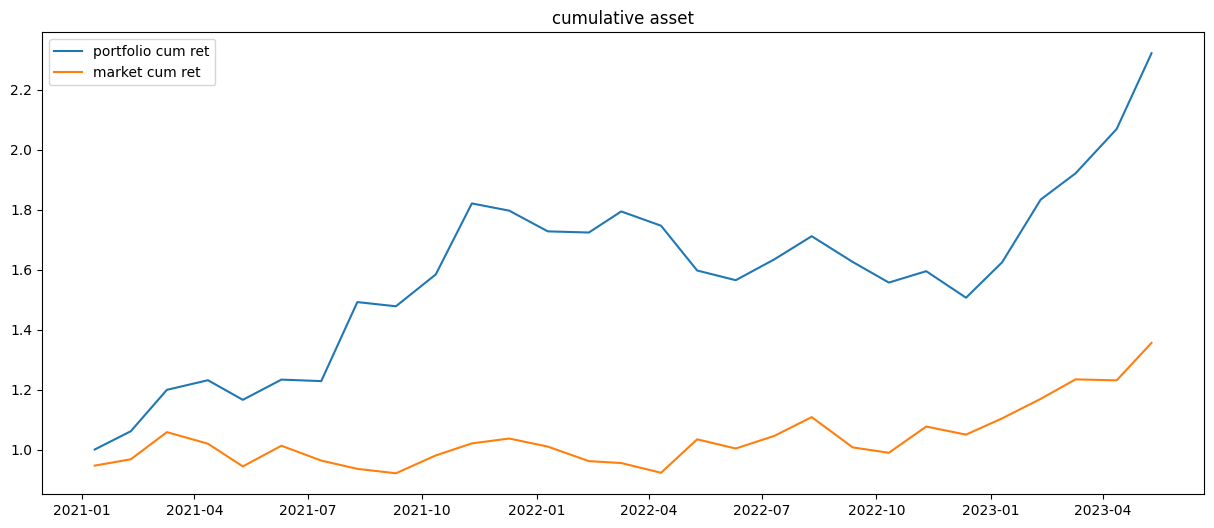

In [7]:
market_cum_asset = np.cumprod(1 + result["return"])
portfolio_cum_asset = np.cumprod(1 + result["performance"])
plt.figure(figsize=(15, 6))
plt.plot(portfolio_cum_asset, label="portfolio cum ret")
plt.plot(market_cum_asset, label = 'market cum ret')
plt.title("cumulative asset") 
plt.legend()
plt.show()

# Check factors
1. check in next revenue date and if has future data
2. credit still dont know future data
3. see factor importance
```
check if drop any useful factors and drop not useful

In [194]:
for i, k in zip(X_train.columns, linear_regression.coef_):
    if k>2 or k<-2:
        print(i, k)

市值(百萬元) -80.05638918050303
市值比重％ 68.70383201626508
單月營收成長率％ 17044871767719.094
單月營收與上月比％ 1895929827671.5144
淨值(千元) 3.646971913764108
流通在外股數(千股)_y 5.05927021421087
以合併為主單月營收成長率％ -17044871767718.996
以合併為主單月營收與上月比％ -1895929827671.476
外資總投資股數(千股) -56.577392578125
外資總投資市值(百萬) -53.65380859375
合計持股數(千股) 52.57489013671875
合計持股數市值(百萬) 65.20849609375
流通在外股數(千股) -3.6552734375
ADE減分 -839294939795.4333
總資產 5.8770751953125
常續性利益 3.6710205078125
CFO 3.83929443359375
營業利益 -6.0037841796875
股東權益 -6.2100830078125


# Predict whole semicond market
#### highlly relate to market tend: use svm to predict market => if predicted matket go down then dont long

In [ ]:
import pickle
plt.figure(figsize=[20, 10])
plt.plot(linear_ret)
plt.axhline(0.004, color = "pink", linestyle = "--", label = "y0.4")

# Detail for each date and EDA

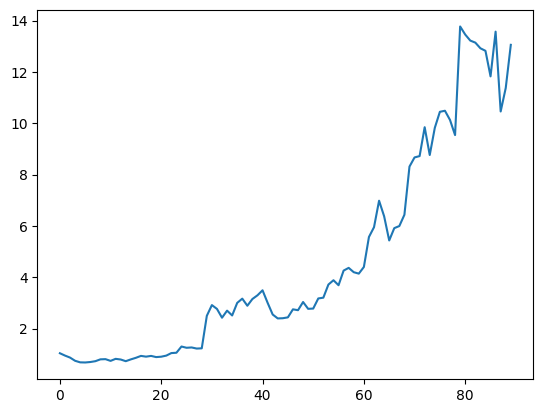

In [30]:
asset = 1
a_list = []
strat = linear_ret[0]#market["報酬率％_週"]# 
for i in range(90):
    if strat[i] != 0:
        asset *= (strat[i] + 1)
    a_list.append(asset)
plt.plot(a_list)

2.936722596173445 10.923011635321965
2.2582351477333567 8.64963394840627


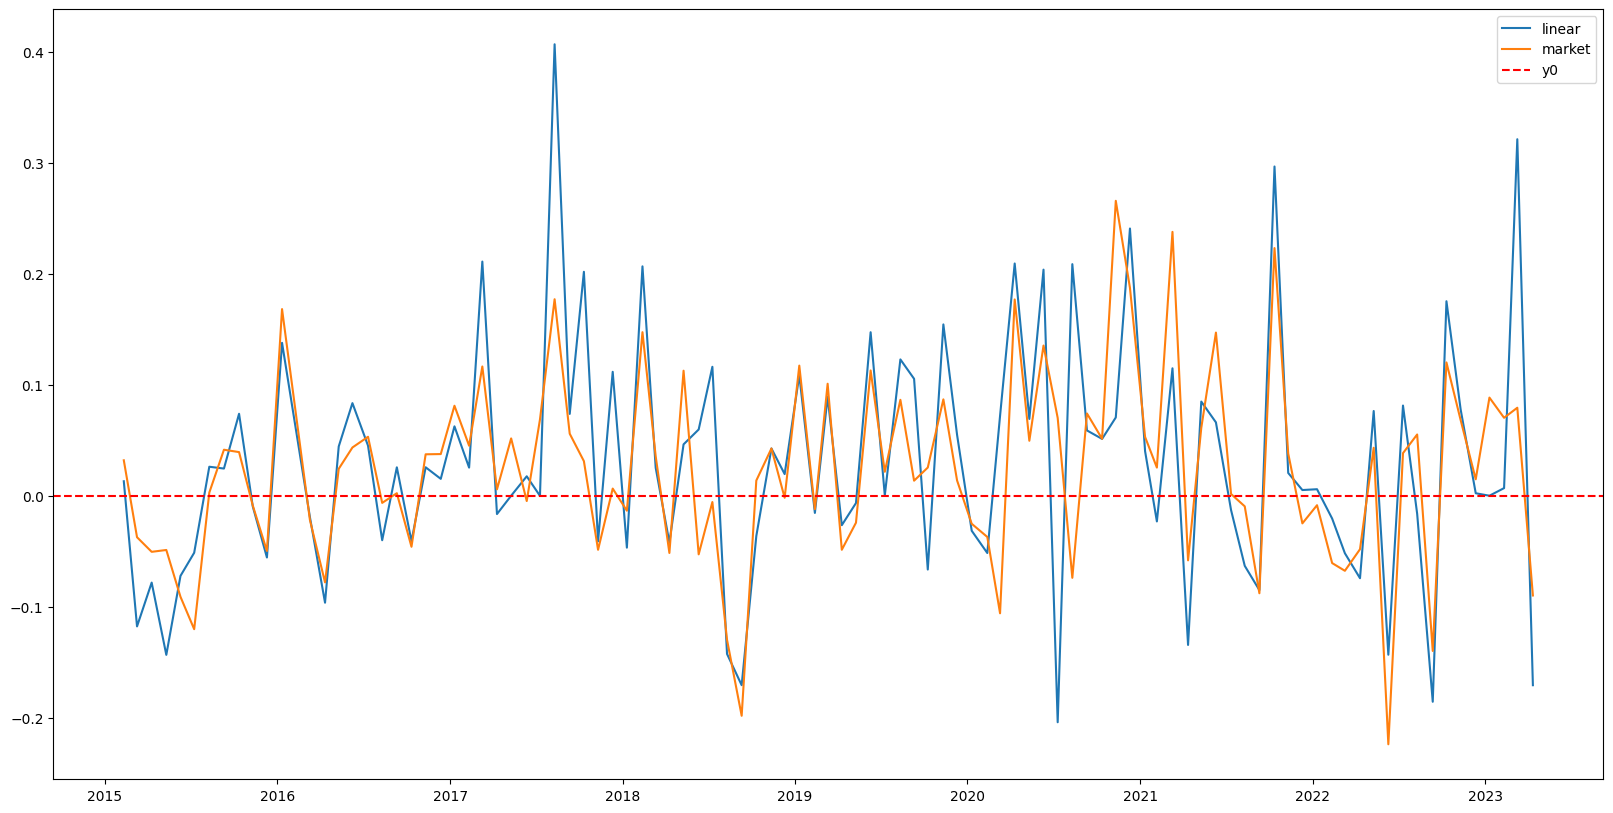

In [36]:
plt.figure(figsize=[20,10])
plt.plot(linear_ret[0], label = "linear")
window_size = 12
linear_ret["s"] = linear_ret[0].rolling(window=window_size, center=True).mean()
market["s"] = market["return"].rolling(window=window_size, center=True).mean()
plt.plot(market["return"], label = "market")
# plt.plot(market["s"], label = "market_smooth")
plt.axhline(0, color = "red", linestyle = "--", label = "y0")
print((linear_ret[0]*100).mean(), (linear_ret[0]*100).std())
print((market["return"]*100).mean(), (market["return"]*100).std())
plt.legend()
plt.show()

# Old version

In [ ]:

def evaluation(returns):
  m = np.mean(returns)
  v = np.std(returns)*math.sqrt(52)
  s = m/v # ignore risk free rate
  return m, v, s


In [ ]:
 # ===========================================================
    # data
    # if class run here
    quantile_20 = np.percentile(y_train, 20)
    quantile_80 = np.percentile(y_train, 80)
    y_train = pd.DataFrame([100 if a > 0.07 else -100 if a < -0.07 else 0 for a in y_train]).set_index(y_train.index)

In [ ]:
# train start from 2015
import gc
gc.collect()



train_start = train_start + pd.DateOffset(months=1)
train_end = train_end + pd.DateOffset(month=1)
test_end = test_end + pd.DateOffset(months=1)
print(train_start)
print(train_end)
print(test_end)
linear_pred = pd.DataFrame()
linear_ret = pd.DataFrame()
y_train_hat = pd.DataFrame()
market = pd.DataFrame()
mean = pd.DataFrame()
i = 0

while True:
      # data
    gc.collect()
    i+=1
    print("-------------rolling {%i}----------------"%i)
    print(train_end)
    X_train, y_train, X_test, y_test = t.Xy(data, start, train_end, test_end)
    if X_test.shape[0] == 0:
        # update data
        start, train_end, test_end = update(start, train_end, test_end)
        continue
    
    # ===========================================================
    # model # np.array(X_train.iloc[:, 1]).reshape(-1, 1)
    linear_regression = linear_model.LinearRegression()
    linear_regression.fit(np.array(X_train), y_train)
    y_hat = list(linear_regression.predict(np.array(X_test)))
    y_hat = pd.DataFrame(y_hat, columns = ["pred"]).set_index(y_test.index)
    y_train_hat = pd.DataFrame(linear_regression.predict(np.array(X_train)), columns = ["pred"]).set_index(y_train.index)
    
    # confidence interval
    train_residual = np.array(y_train_hat) - np.array(y_train)
    long_ci = 1  + train_residual.std() * 0.1
    short_ci  = -1 - train_residual.std() * 0.1
    
    # %
        
    # quantile sort and return
    linear_pred, linear_ret = compute_ret(y_test, y_hat, linear_pred, linear_ret, long, short)
    mean = pd.concat([mean, y_hat.groupby(["ymd"]).mean()], axis = 0)
    print(linear_ret.mean())
    
    # ===========================================================
    date = y_test.reset_index()["ymd"].unique()
    market = pd.concat([market, y_test.reset_index().groupby("ymd").mean()], axis = 0)
    
    # ===========================================================
    # store result: in result
    # returns: non categorised | class: categorised
    with open("result/linear_ret_returns.pickle", "wb") as f: 
        pickle.dump(linear_ret, f) 
    with open("result/linear_pred_returns.pickle", "wb") as f:
        pickle.dump(linear_pred, f) 
        
    # ===========================================================
    # update data
    
    start, train_end, test_end = update(start, train_end, test_end)
    if test_end > max(data.reset_index()["ymd"]):
        break

In [ ]:
date = linear_ret.reset_index()["年月日"].unique()
y_hat = linear_pred
ret = pd.DataFrame()
for k in date:
    date_hat = y_hat.reset_index()[y_hat.reset_index()["年月日"] == k].set_index(["證券代碼", "年月日"])
    long_ = np.percentile(date_hat["pred"], 95)
    short_ = np.percentile(date_hat["pred"], 5)
    pred_l = [1 if a > long_ else 0 for a in date_hat["pred"]]
    pred_s = [-1 if a < short_ else 0 for a in date_hat["pred"]]
    date_hat["pred_ls"] = [pred_l[i] + pred_s[i] for i in range(len(pred_l))]
    date_hat['weight'] = date_hat["pred"]*pred_l/sum(date_hat["pred"]*pred_l*2) +\
                            date_hat["pred"]*pred_s/sum(date_hat["pred"]*pred_s*2)  
    if sum(date_hat["pred"]*pred_s*2) == 0 or sum(date_hat["pred"]*pred_l*2) == 0:
        date_hat['weight'] = date_hat["pred"]*pred_l/sum(date_hat["pred"]*date_hat["pred_ls"])
    # print(date)
    print(f" ========================================\n\
                check weight {abs((date_hat['weight']*date_hat['pred_ls'])).sum()}")
    print(f" == > long stock and date {long}/ {date_hat[date_hat['pred_ls'] == 1]}")
    print(f" == > short stock and date {date_hat[date_hat['pred_ls'] == -1]}")
    returns = date_hat["true"]*date_hat["pred_ls"]*date_hat["weight"] # compute returns with  different weight
    ret = pd.concat([ret, returns.reset_index().groupby("年月日").sum()], axis = 0)
    print(ret.mean())
    

# Elastic

In [59]:
from sklearn.model_selection import train_test_split
def tune_ela(X_train, y_train, best_alpha, best_l1_ratio):
    error = 10000

    if best_alpha is not None:
          elastic_net = linear_model.ElasticNet(alpha=best_l1_ratio, l1_ratio=best_alpha, random_state = 321, max_iter = 500)
          elastic_net.fit(X_train, y_train)
          error = mean_squared_error(y_test, elastic_net.predict(X_test))

    
    X_train_tune, X_val, y_train_tune, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = False)

    for i in range(60):
        config = {
                "alpha" : min(1, abs(np.random.normal(0, 0.1))),
                "l1_ratio" : np.random.uniform(0, 1)
                }
        if config["alpha"] == 1:
            continue
        elastic_net = linear_model.ElasticNet(alpha=config["alpha"], l1_ratio=config["l1_ratio"], random_state = 321, max_iter = 500)
        elastic_net.fit(X_train_tune, y_train_tune)
        if mean_squared_error(y_val, elastic_net.predict(X_val)) < error:                
            error = mean_squared_error(y_val, elastic_net.predict(X_val))
            best_alpha = config["alpha"]
            best_l1_ratio = config["l1_ratio"]
            print(f"tune {i}: loss {error} | \
                  best_alpha:{round(best_alpha, 3)},\
                  best_l1_ratio:{round(best_l1_ratio, 3)}")
    return best_alpha, best_l1_ratio

In [60]:
# elastic net
start, train_end, test_end = initialization(data)
start = pd.to_datetime("20180101", format="%Y%m%d")
start, train_end, test_end = update(start, train_end, test_end)
regela_pred = pd.DataFrame()
regela_ret = pd.DataFrame()
y_train_hat = pd.DataFrame()
i = 0
best_alpha, best_l1_ratio = None, None

while True:
      # data
    i+=1
    print("-------------rolling {%i}----------------"%i)
    X_train, y_train, X_test, y_test = split_data(data, start, train_end, test_end)
    if X_test.shape[0] == 0:
        start, train_end, test_end = update(start, train_end, test_end)
        continue
    
    # ===========================================================
    # if class run here
    """quantile_20 = np.percentile(y_train, 20)
    quantile_80 = np.percentile(y_train, 80)
    y_train = [100 if a > 7 else -100 if a < -7 else 0 for a in y_train]"""
    # ===========================================================

    # model
    best_alpha, best_l1_ratio = tune_ela(X_train, y_train, best_alpha, best_l1_ratio)
    elastic_net = linear_model.ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state = 321, max_iter = 500)
    elastic_net.fit(X_train, y_train)
    y_hat = elastic_net.predict(X_test)
    y_train_hati = pd.DataFrame(elastic_net.predict(X_train), columns = ["pred"]).set_index(y_train.index)
    y_train_hat = pd.concat([y_train_hat, y_train_hati], axis = 0)
    
    # quantile sort and return
    long = np.percentile(y_train_hat, 90)
    short = np.percentile(y_train_hat, 0)
    y_hat = pd.DataFrame(y_hat, columns = ["pred"]).set_index(y_test.index)
    regela_pred, regela_ret = compute_ret(y_test, y_hat, regela_pred, regela_ret, long, short)
    print(regela_ret.mean())
    
    # store, in result
    with open("result/regela_ret_returns.pickle", "wb") as f: 
        pickle.dump(regela_ret, f) 
    with open("result/regela_pred_returns.pickle", "wb") as f:
        pickle.dump(regela_pred, f) 
    # update data
    start, train_end, test_end = update(start, train_end, test_end)
    if test_end > max(data.reset_index()["年月日"]):
      break

-------------rolling {1}----------------
tune 0: loss 19.199638094036377 |                   best_alpha:0.109,                  best_l1_ratio:0.829
tune 3: loss 19.172969608418644 |                   best_alpha:0.15,                  best_l1_ratio:0.323
check weight 0.9999999999999998
long stock and date 0.32906365358848266/                            true  pred_ls      pred    weight
證券代碼        年月日                                             
2408 南亞科    2020-01-10  -0.8303        1  0.712331  0.129730
5269 祥碩     2020-01-10  19.7567        1  0.940620  0.171306
6415 矽力*-KY 2020-01-10   0.9259        1  2.024717  0.368742
3661 世芯-KY  2020-01-10  11.8421        1  0.385660  0.070237
6451 訊芯-KY  2020-01-10  -1.2347        1  0.527244  0.096022
8028 昇陽半導體  2020-01-10  -0.2878        1  0.900304  0.163964
short stock and date Empty DataFrame
Columns: [true, pred_ls, pred, weight]
Index: []
0    4.284146
dtype: float64
-------------rolling {2}----------------
tune 0: loss 20.8753131255216

In [56]:
print(regela_ret.mean(), regela_ret.std())

0    2.205654
dtype: float64 0    5.578894
dtype: float64
